In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# import xgboost as xgb

import constants




/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# LOAD DATA

In [2]:
# with open("all_data_15_min_20_grid_2019.txt", "rb") as fp:   # Unpickling
#     all_data = pickle.load(fp)
    
with open("all_data_15_min_20_grid.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)

# with open("grid_labels_20_2019.txt", "rb") as fp:   # Unpickling
#     grid_labels = pickle.load(fp)
    
with open("grid_labels_20.txt", "rb") as fp:   # Unpickling
    grid_labels = pickle.load(fp)

In [3]:
# Remove datapoints that are either corrupted or outside the range where it can be accurately measured
all_data = all_data[all_data['PM2.5'] > 0.2]
all_data = all_data[all_data['humidity'] < 80]

# Create Model

In [4]:
def createStationaryModel(num_layers = 2, lr = 0.00001, num_cells = 12):
    model_layers = [layers.Dense(num_cells, activation=tf.nn.relu, input_shape=[len(constants.CONTINUOUS_TRAINING_FEATURES)])]
    
    for layer in range(num_layers - 1):
        model_layers.append(layers.Dense(num_cells, activation=tf.nn.relu))
        
    model_layers.append(layers.Dense(1))
    
    online_model = tf.keras.Sequential(model_layers)
    
    online_optimizer = tf.keras.optimizers.Adam(lr)

    online_model.compile(loss='mean_absolute_error',
        optimizer=online_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
    par = PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3)
    
    return online_model, par


In [5]:
online_model, par_model = createStationaryModel()

Instructions for updating:
Colocations handled automatically by placer.


# Train Functions

In [10]:
def updateModels(data):
    label = data.pop('next_pm_2.5')
    X = data[constants.CONTINUOUS_TRAINING_FEATURES]
    label = np.array(label)
    
    online_model.fit(
        X, label, batch_size=len(data),
        epochs=5, verbose=0)

    par_model.partial_fit(X, label)
                
def trainNNs(train_data):
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    labels = []
    X = pd.DataFrame(columns = constants.CONTINUOUS_TRAINING_FEATURES)
    
    start = int(train_data['timestepContinuous'].min())
    end = int(train_data['timestepContinuous'].max())
    for i in range(start, end):
        cur_data = train_data[train_data['timestepContinuous'] == i]
        #Get list of all coords
        lat_coords = np.array(cur_data['lat_grid'])
        long_coords = np.array(cur_data['long_grid'])
                
        for x, y in zip(lat_coords, long_coords):
            x = int(x)
            y = int(y)
            
            #Check which coords have data next step
            if(grid_labels[i + 1][x][y] != None):
                #Append curData for coords that do have data next step
                new_input = cur_data[(cur_data['lat_grid'] == x) & (cur_data['long_grid'] == y)][constants.CONTINUOUS_TRAINING_FEATURES]
                X = pd.concat([X, new_input])
                #Append grid data to labels
                labels.append(grid_labels[i + 1][x][y])
        
    early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=50)

    par_model.fit(X, labels)

    history = online_model.fit(
        X, labels, batch_size=16,
        epochs=1, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])

    plot_history(history)
    hist = pd.DataFrame(history.history)
    display(hist)
    
def trainNNnn(trainData):
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    
        
    X = trainData[constants.CONTINUOUS_TRAINING_FEATURES]
    labels = trainData.pop('next_pm_2.5')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

    par_model.fit(X, labels)

    history = online_model.fit(
        X, labels, batch_size=8,
        epochs=6000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])
#         epochs=2000, verbose=0, validation_split = .2, callbacks=[ early_stop])

    plot_history(history)
    hist = pd.DataFrame(history.history)
    display(hist)
    
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

# Test Time Functions

In [11]:
def copy_model(model):
    batch_model = keras.models.clone_model(model)
    batch_model.build((None, len(constants.CONTINUOUS_TRAINING_FEATURES)))
    batch_model.compile(optimizer='adam', loss='mean_absolute_error')
    batch_model.set_weights(model.get_weights())
    
    return batch_model

def predictOneTimestep(data):
    online_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    batch_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    par_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    baseline_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    
    #get each datapoint in df and check coords and place in grid
    if (len(data) > 0):
        for index, row in data.iterrows():
            x = int(row['lat_grid'])
            y = int(row['long_grid'])
            columns = list(row.index)
            if([x,y] in constants.STATIC_COORDS_GRID.values()):
                online_pred, batch_pred, par_pred, baseline_pred = predictOneDataPoint(pd.DataFrame(row).transpose())
                online_pred_matrix[x][y] = online_pred
                batch_pred_matrix[x][y] = batch_pred
                par_pred_matrix[x][y] = par_pred
                baseline_pred_matrix[x][y] = baseline_pred

    return online_pred_matrix, batch_pred_matrix, par_pred_matrix, baseline_pred_matrix

def predictOneDataPoint(X):
    X = np.array(X[constants.CONTINUOUS_TRAINING_FEATURES])
    online_pred = online_model.predict(X)
    batch_pred = batch_model.predict(X)
    par_pred = par_model.predict(X)
    baseline_pred = X[0][0]
    
    return (online_pred[0][0], batch_pred[0][0], par_pred[0], baseline_pred)
    
def get_valid_preds(timestep, online_pred_matrix, batch_pred_matrix, par_pred_matrix, baseline_pred_matrix):
    labels = []
    online_preds = []
    batch_preds = []
    par_preds = []
    baseline_preds = []
    
    for x in range(constants.GRID_SIZE):
        for y in range(constants.GRID_SIZE):
            if(grid_labels[timestep + 1][x][y] != None and ([x,y] in constants.STATIC_COORDS_GRID.values())):
#             if(grid_labels[timestep + 1][x][y] != None and ([x,y] in [[3,6]])):
                if((online_pred_matrix[x][y] != None) and (batch_pred_matrix[x][y] != None) and(par_pred_matrix[x][y] != None)):
                    online_preds.append(online_pred_matrix[x][y])
                    batch_preds.append(batch_pred_matrix[x][y])
                    par_preds.append(par_pred_matrix[x][y])
                    labels.append(grid_labels[timestep + 1][x][y])
                    baseline_preds.append(baseline_pred_matrix[x][y])
    
    return (np.array(online_preds), np.array(batch_preds), par_preds, baseline_preds, labels)
    

def getFullPredictions(data):
    online_predictions = []
    batch_predictions = []
    ensemble = []
    baseline = []
    par_predictions = []
    all_labels = []
    
    flat_online_preds = []
    flat_batch_preds = []
    flat_par_preds = []
    flat_ensemble_preds = []
    flat_baseline_preds = []
    
    for i in range(int(data['timestepContinuous'].min()), int(data['timestepContinuous'].max()) - 1):
#     for i in range(1522, 1550):
        newData = data[data['timestepContinuous'] == i]
#         print(i)
        if(len(newData) > 0):
            for index, row in newData.iterrows():
                online_pred_matrix, batch_pred_matrix, par_pred_matrix, baseline_pred_matrix = predictOneTimestep(pd.DataFrame(row).transpose())

                online_pred, batch_pred, par_pred, baseline_pred, labels = get_valid_preds(i, online_pred_matrix, batch_pred_matrix, par_pred_matrix, baseline_pred_matrix)

                flat_online_preds.extend(online_pred)
                flat_batch_preds.extend(batch_pred)
                flat_par_preds.extend(par_pred)
                flat_baseline_preds.extend(baseline_pred)
                all_labels.extend(labels)


        #             ensemble_pred = (.5 * online_pred) + (.5 * batch_pred)


        #             flat_ensemble_preds.append(ensemble_pred)

                updateModels(pd.DataFrame(row).transpose())
    return (flat_online_preds, flat_batch_preds, flat_par_preds, flat_baseline_preds, all_labels)


In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

learning rate: 0.001 cells: 8

....................................................................................................
....................................................................................................
....................................................................................................
......................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,0.475599,0.475599,1.062133,0.553460,0.553460,0.419863
1,0.243727,0.243727,0.962258,0.593913,0.593913,0.439236
2,0.224525,0.224525,1.001790,0.598483,0.598483,0.444680
3,0.224112,0.224112,0.983473,0.540030,0.540030,0.377560
4,0.222276,0.222277,1.001032,0.557501,0.557501,0.396596
...,...,...,...,...,...,...
381,0.197768,0.197768,0.600672,0.328924,0.328924,0.178050
382,0.198860,0.198860,0.600631,0.348564,0.348564,0.191239
383,0.198127,0.198127,0.600214,0.301615,0.301615,0.161082
384,0.198704,0.198704,0.600705,0.328360,0.328360,0.177911


online: 0.1686066699739076
batch: 0.16288533319272078
ensemble: 0.14462856636926855
baseline: 0.13034867344823164
par: 0.23191313188789944


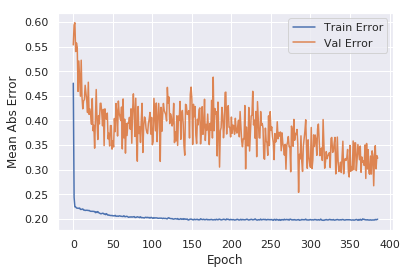

In [13]:
# learning_rates = [.01, 0.001, 0.0001]
# num_cells = [2,4,8,16,32,64]

learning_rates = [0.001]
num_cells = [8]
for lr in learning_rates:
    for cells in num_cells:
        print('learning rate: ' + str(lr) + ' cells: ' + str(cells))
        online_model, _ = createStationaryModel(1, lr, cells)
        train = all_data[all_data['timestepContinuous'] <= 1450]
        valid = all_data[(all_data['timestepContinuous'] > 1450)]

        columns= valid.columns
        stationary_train = pd.DataFrame(columns=columns)
        for coords in constants.STATIC_COORDS_GRID.values():
            x = int(coords[0])
            y = int(coords[1])
            curData = train[(train['lat_grid'] == x) & (train['long_grid'] == y)]
            stationary_train = stationary_train.append(curData)

        train = stationary_train
        trainNNnn(train)
        

        batch_model = copy_model(online_model)
        online_preds, batch_predictions, par_preds, baseline_preds, labels = getFullPredictions(valid)
        ensemble_preds = []
        for online, batch in zip(online_preds, batch_predictions):
            ensemble_preds.append((.5 * online + .5 * batch))

        print('online: ' + str(mean_absolute_error(np.array(online_preds), np.array(labels))))
        print('batch: ' + str(mean_absolute_error(batch_predictions, labels)))
        print('ensemble: ' + str(mean_absolute_error(ensemble_preds, labels)))
        print('baseline: ' + str(mean_absolute_error(baseline_preds, labels)))
        print('par: ' + str(mean_absolute_error(par_preds, labels)))
                


In [ ]:
osm_dir = "/Users/ryanegan/Documents/diss/"
filename = osm_dir + "prediction_sample_grid_" + str(constants.GRID_SIZE) + ".csv"
with open(filename, 'w') as csvfile:
    writer = csv.writer(csvfile, lineterminator='\n')
    writer.writerows(online_preds[300])

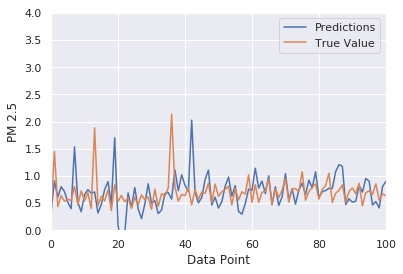

In [16]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Data Point')
    plt.ylabel('PM 2.5')
    plt.plot(x, preds,
           label='Predictions')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,4])
    plt.xlim([0, 100])
    plt.legend()
    plt.savefig('online_10_epochs.png')
    plt.show()
    
plot_preds(online_preds, labels)
